# Vehicle Detection
### by Kilian Muelken

---
#### Code Cell 1: necessary imports for the code

In [1]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.externals import joblib
import copy
from scipy.ndimage.measurements import label

___
## Part 1: Vehicle detection functions
*Functions for the vehicle Detection*

### Part 1.1: Common functions

___
#### Code Cell ?: Calculate sliding windows
**Input:** image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y)<br>
**Output:** List of sliding windows

In [2]:
def calcSlideWindows(img):
    xy_window=(64, 64)
    xy_overlap=(0.5, 0.5)
    x_start = 0
    x_stop = img.shape[1]
    y_start = int(img.shape[0] * 0.5) # should be the highest place in the image, where cars can be seen
    y_stop = img.shape[0] # above the bonnet
        
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    slidingWindows = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list
            slidingWindows.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return slidingWindows

___
#### Code Cell ?: Plot and save images
**Input:** list of images<br>
**Output:** plots and saves images

In [3]:
def plotImage(imgs, save=False):
    # check if imgs is a list
    imglist = []
    
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist.append(imgs)
        
    n_img = len(imglist)
    
    plt.figure(figsize=(20,5))
    
    for i in range(n_img):
        # plot image
        n_plot = 101 + n_img*10 + i
        plt.subplot(n_plot) # source: https://stackoverflow.com/questions/35692507/plot-several-image-files-in-matplotlib-subplots
        plt.imshow(imglist[i])
        
        # save image if save=true
        if save:
            #img_BGR = cv2.cvtColor(img_list[i],cv2.COLOR_RGB2BGR)
            img_name = 'image_'+time.strftime('%m_%Y_%H_%M_%S')+'.jpg'
            mpimg.imsave('output_images/'+img_name, imglist[i])

___
#### Code Cell ?: Draw bounding boxes
**Input:** image to draw the boxes, position and size of the boxes<br>
**Output:** image with boxes drawn

In [4]:
def drawBoxes(img, bboxes):
    color = (0, 0, 255) # Color of the boxes is blue
    thick = 6  # thickness of the boxes
    
    img_boxes = np.copy(img) # Make a copy of the image
    
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(img_boxes, bbox[0], bbox[1], color, thick) # Draw a rectangle given bbox coordinates
    
    return img_boxes # return the image with boxes drawn

#### Code Cell ?: Read test images
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [5]:
def readImages(path):
    images = []
    images_list = glob.glob(path) # Make a list of calibration images

    # Step through the list, read test images and convert them to RGB
    for fname in images_list:
        img = cv2.imread(fname)
        rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(rgb)
    return images

___
#### Code Cell ?: Search for positive matches in windows
*Uses extractFeatures()*
**Input:** Image, Silde windows, Classifier, Scaler<br>
**Output:** positive matches in windows

In [6]:
def searchPositiveWindows(img, windows, clf, scaler):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = extractFeatures(test_img)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows

___
#### Code Cell ?: Check if windows are overlapping
**Input:** 2 Windows<br>
**Output:** Boolean (True if they are overlapping)

In [7]:
# check if windows overlap
def overlapWindow(win1, win2):
    x_left_w1 = win1[0][0] # x positition of the left upper point of the first window
    y_top_w1 = win1[0][1] # y positition of the left upper point of the first window
    x_right_w1 = win1[1][0] # x positition of the right bottom point of the first window
    y_bottom_w1 = win1[1][1] # y positition of the right bottom point of the first window
    
    x_left_w2 = win2[0][0] # x positition of the left upper point of the second window
    y_top_w2 = win2[0][1] # y positition of the left upper point of the second window
    x_right_w2 = win2[1][0] # x positition of the right bottom point of the second window
    y_bottom_w2 = win2[1][1] # y positition of the right bottom point of the second window
    
    # if left upper point of the first window is in the second window
    if ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
            
    # if right upper point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if left bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if right bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if there is no overlapping
    else:
        overlap = False
    
    return overlap

___
#### Code Cell ?: Find and eliminate false positive windows
**Input:** Detected windows with cars<br>
**Output:** Windows with eliminated false positives

In [8]:
def falsePositives(windows, last_windows):
    
    # Create an empty list to receive positive detection windows
    windows_eliminated = []
    
    # Iterate over all windows in the list
    for window in windows:        
        for last_window in last_windows:            
            if overlapWindow(window, last_window):
                windows_eliminated.append(window)
    
    return windows_eliminated

___
#### Code Cell ?: Find and merge mulitple detections
**Input:** Detected windows with cars<br>
**Output:** windows with merged multiple detections

In [9]:
def multipleDetectionsOld(windows):
    
    #### 1. seperate all windows in different window groups and put overlapping windows in the same group
    window_groups = []
    
    #### 1.1 allocate windows to window groups
    for window1o in windows: # take a window from the list
        window1 = copy.copy(window1o)
        firstmatch = True # is true for the first match
        
        # 1.1.1 check if the window overlaps with a window in the window groups
        for win_group in window_groups: # go through exisiting window groups
            for window2 in win_group: # go through windows in the window group
                if overlapWindow(window1, window2): # check if the first window overlaps with a window
                    
                    # copy window group and append current window
                    if firstmatch: 
                        window_group = copy.deepcopy(win_group) # copy this group
                        window_groups.remove(win_group) # remove the group from the lsit of window groups
                        window_group.append(window1) # append the window to the window group
                        windows.remove(window1o) # remove current window from window list, because it is in a window group
                        firstmatch = False
                        
                    # if there are more matches, merge both window groups
                    else:
                        for window3 in win_group:
                            if window3 not in window_group:
                                window_group.append(window3)
                        
                        if win_group in window_groups:
                            window_groups.remove(win_group) # remove the group from the lsit of window groups
        
        # 1.1.2 if there is no overlap with a window of a existing group          
        if firstmatch:
            window_group = [] # make a new group
            window_group.append(window1) # append current window to group
            windows.remove(window1o) # delete current window from window list, because it is in a window group
        
        # append window group to list of window groups
        window_groups.append(window_group)


    #### 2. calculate the total windows for each group ##################################################
    windows_multiDetect = []
    print(window_groups)
    for win_group in window_groups:
        xul = min(win[0][0] for win in win_group)
        yul = min(win[0][1] for win in win_group)
        xbr = max(win[1][0] for win in win_group)
        ybr = max(win[1][1] for win in win_group)
                
        total_window = ((xul, yul), (xbr, ybr))
        windows_multiDetect.append(total_window)
    
    return windows_multiDetect

In [23]:
def addHeat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # normalize heatmap
    heatmap /= 4
        
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def getbboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        bboxes.append(bbox)

    # Return the bboxes
    return bboxes

        
def multipleDetections(image, windows):
    threshold = 0.1
    
    new_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # define a map to add the heat
    if ('heatmap' not in globals()):
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # add new heat to the map
    new_heatmap = addHeat(new_heatmap, windows)
        
    # calculate average with old heat
    heatmap = (2*new_heatmap + heatmap) / 3.0
    
    print(heatmap.max())
    
    # reduce heat less than threshold
    heatmap[heatmap <= threshold] = 0
    
    # detect cars on image
    labels = label(heatmap)
    
    # get boxes around the detected cars
    windows_final = getbboxes(labels)
    
    # draw boxes on the image
    image_final = drawBoxes(image, windows_final)
    
    return image_final
    

___
### Part 1.2: Feature functions

___
#### Code Cell ?: Compute HOG features
**Input:** Image<br>
**Output:** HOG features

In [11]:
def hogFeatures(img):
    orientations = 9
    pix_per_cell = 8
    pixels_per_cell=(pix_per_cell, pix_per_cell)
    cell_per_block = 2
    cells_per_block=(cell_per_block, cell_per_block)
    block_norm = 'L2-Hys'
    transform_sqrt = True
    visualise = False
    feature_vector = True
    hog_channel = 'ALL'
      
    if hog_channel == 'ALL':
        features = []
        for channel in range(img.shape[2]):
            features_channel = hog(img[:,:,channel], orientations=orientations, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=visualise, feature_vector=feature_vector)
            features.append(features_channel)
        features = np.ravel(features)
    else:
        img_hog = img[:,:,hog_channel]
        features = hog(img_hog, orientations=orientations, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), 
                    block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=visualise, feature_vector=feature_vector)
    return features

___
#### Code Cell ?: Compute binned color features 
**Input:** Image<br>
**Output:** binned color features

In [12]:
def binSpatial(img):
    size=(32, 32)
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

___
#### Code Cell ?: Compute color histogram features 
**Input:** Image<br>
**Output:** binned color features

In [13]:
def colorHist(img):
    nbins=32
    bins_range=(0, 256) # NEED TO CHANGE bins_range if reading .png files with mpimg!
        
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return features

___
#### Code Cell ?: Extract features 
*Uses hogFeatures(), binSpatial() and colorHist()*
**Input:** Image<br>
**Output:** features

In [14]:
def extractFeatures(imgs):
    color_space = 'YCrCb'
    spatial_feat = True
    hist_feat  =True
    hog_feat = True
    
    # check if imgs is a list
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist = []
        imglist.append(imgs)
        
    # Create a list to append feature vectors to
    features = []
    
    for img in imglist:
        img_features = []
    
        # color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img) 

        # Compute binned color features
        if spatial_feat == True:
            spatial_features = binSpatial(feature_image)
            img_features.append(spatial_features)
            

        # Compute color histogram features
        if hist_feat == True:
            hist_features = colorHist(feature_image)
            img_features.append(hist_features)
            

        # Compute HOG features
        if hog_feat == True:
            hog_features = hogFeatures(feature_image)
            img_features.append(hog_features)

        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

___
## Part ?: Training of the Classifier
*Training of the Classifier with test images*<br>

#### Code Cell ?: Training Pipeline
**Input:** path of the training images<br>
**Output:** trained classifier

In [15]:
def trainingPipeline(cars, notcars):
    n_cars = len(cars)
    n_notcars = len(notcars)
    
    if n_cars < n_notcars:
        notcars = notcars[0:n_cars]
    elif n_notcars < n_cars:
        cars = cars[0:n_notcars]
    
    car_features = extractFeatures(cars)
    notcar_features = extractFeatures(notcars)
        
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

In [16]:
training = False # Set to True for new training

if training:
    # read train images
    notcars = readImages('train_nv/*.png')
    cars = readImages('train_v/*.png')

    clf, scaler = trainingPipeline(cars, notcars)

    # save the classifier and scaler to the disk
    # source: http://scikit-learn.org/stable/modules/model_persistence.html
    joblib.dump(clf, 'clf.pkl')
    joblib.dump(scaler, 'scaler.pkl')

In [17]:
# load the classifier and scaler
# source: http://scikit-learn.org/stable/modules/model_persistence.html
clf = joblib.load('clf.pkl')
scaler = joblib.load('scaler.pkl')

___
## Part ?: Testing
*Test of the Classifier with test images and test video*<br>

___
#### Code Cell ?: Image Testing Pipeline
*Test of the Classifier with test images*<br>
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [18]:
def imagePipeline(img):
    global heatmap # detected windows from the last image
    
    image = np.copy(img) # Make a copy of the image
    
    # calculate the searching windows
    slide_windows = calcSlideWindows(image)
    
    # find positive matches in searching windows
    car_windows = searchPositiveWindows(image, slide_windows, clf, scaler)
    print(car_windows)
    
    # delete false positives
    #if ('last_heat' in globals()):
        #if len(last_windows) > 0:
            #windows_pos_fp = falsePositives(windows_pos, last_windows)
        #else:
            #windows_pos_fp = windows_pos
    #else:
        #windows_pos_fp = windows_pos
    
    # save the detection for the next image
    #last_windows = windows_pos
    
    # merge multiple detections
    image_cars = multipleDetections(image, car_windows)
    
    # draw the detections on the image
    #res_img = drawBoxes(image, windows_pos_md)
    #res_img = windows_pos_md
    
    return image_cars

[((864, 392), (928, 456)), ((864, 424), (928, 488))]
0.25
[]
0.0
[((896, 424), (960, 488))]
0.125
[((1184, 424), (1248, 488))]
0.125
[((832, 392), (896, 456)), ((864, 392), (928, 456)), ((1120, 392), (1184, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((1184, 456), (1248, 520))]
0.5
[((832, 424), (896, 488)), ((864, 424), (928, 488))]
0.25


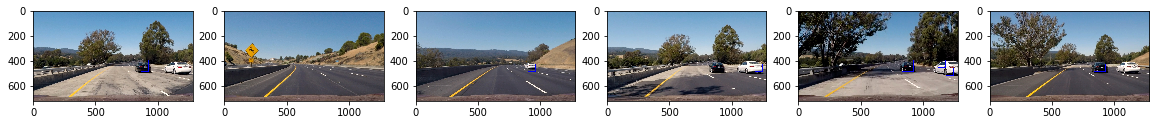

In [19]:
# read test images
test_images = readImages('test_images/*.jpg')

images = []

for test_image in test_images:
    # pipeline
    test_image_detected = imagePipeline(test_image)
    images.append(test_image_detected)
    
plotImage(images)

___
#### Code Cell ?: Video Pipeline
*Test of the Classifier with test video*<br>
**Input:** path of the test video<br>
**Output:** video with marked detected vehicles

In [20]:
def videoPipeline(img):
    # Sliding window
    res_img = imagePipeline(img)
    
    return res_img

#### Code Cell ?: Detect vehicles on video
**Input:** name of the test video<br>
**Output:** video with marked detected vehicles will be written in current folder

In [24]:
def detectVehicles(video_file_name):
    #clip = VideoFileClip(video_file_name+'.mp4')
    clip = VideoFileClip(video_file_name+'.mp4').subclip(15,20)
    video_clip = clip.fl_image(videoPipeline)
    %time video_clip.write_videofile(video_file_name+'_with_detected_vehicles.mp4', audio=False)

In [25]:
detectVehicles('project_video')

[((960, 424), (1024, 488))]
0.166666666667
[MoviePy] >>>> Building video project_video_with_detected_vehicles.mp4
[MoviePy] Writing video project_video_with_detected_vehicles.mp4



  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

[((960, 424), (1024, 488))]
0.166666666667



  1%|▋                                                                                 | 1/126 [00:02<04:10,  2.00s/it]

[((960, 424), (1024, 488)), ((1056, 424), (1120, 488))]
0.166666666667



  2%|█▎                                                                                | 2/126 [00:04<04:10,  2.02s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1056, 424), (1120, 488))]
0.333333333333



  2%|█▉                                                                                | 3/126 [00:06<04:08,  2.02s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1056, 424), (1120, 488))]
0.333333333333



  3%|██▌                                                                               | 4/126 [00:08<04:17,  2.11s/it]

[((960, 424), (1024, 488)), ((1056, 424), (1120, 488))]
0.166666666667



  4%|███▎                                                                              | 5/126 [00:10<04:10,  2.07s/it]

[((960, 424), (1024, 488))]
0.166666666667



  5%|███▉                                                                              | 6/126 [00:12<04:05,  2.04s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



  6%|████▌                                                                             | 7/126 [00:14<03:59,  2.02s/it]

[((992, 424), (1056, 488))]
0.166666666667



  6%|█████▏                                                                            | 8/126 [00:16<03:56,  2.01s/it]

[((1024, 424), (1088, 488))]
0.166666666667



  7%|█████▊                                                                            | 9/126 [00:18<04:00,  2.06s/it]

[((1024, 424), (1088, 488))]
0.166666666667



  8%|██████▍                                                                          | 10/126 [00:20<03:58,  2.05s/it]

[((1024, 424), (1088, 488))]
0.166666666667



  9%|███████                                                                          | 11/126 [00:22<03:51,  2.01s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 10%|███████▋                                                                         | 12/126 [00:24<03:45,  1.98s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 10%|████████▎                                                                        | 13/126 [00:26<03:38,  1.93s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 11%|█████████                                                                        | 14/126 [00:27<03:27,  1.85s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 12%|█████████▋                                                                       | 15/126 [00:29<03:28,  1.88s/it]

[]
0.0



 13%|██████████▎                                                                      | 16/126 [00:31<03:31,  1.92s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 13%|██████████▉                                                                      | 17/126 [00:33<03:29,  1.92s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 14%|███████████▌                                                                     | 18/126 [00:35<03:30,  1.95s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 15%|████████████▏                                                                    | 19/126 [00:37<03:29,  1.95s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 16%|████████████▊                                                                    | 20/126 [00:39<03:26,  1.95s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 17%|█████████████▌                                                                   | 21/126 [00:41<03:21,  1.92s/it]

[((1024, 424), (1088, 488))]
0.166666666667



 17%|██████████████▏                                                                  | 22/126 [00:43<03:14,  1.87s/it]

[((928, 424), (992, 488)), ((1024, 424), (1088, 488))]
0.166666666667



 18%|██████████████▊                                                                  | 23/126 [00:45<03:16,  1.90s/it]

[((928, 424), (992, 488)), ((1024, 424), (1088, 488))]
0.166666666667



 19%|███████████████▍                                                                 | 24/126 [00:46<03:09,  1.86s/it]

[((928, 424), (992, 488)), ((1024, 424), (1088, 488))]
0.166666666667



 20%|████████████████                                                                 | 25/126 [00:48<03:08,  1.87s/it]

[((928, 424), (992, 488)), ((1024, 424), (1088, 488))]
0.166666666667



 21%|████████████████▋                                                                | 26/126 [00:50<03:07,  1.87s/it]

[((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 21%|█████████████████▎                                                               | 27/126 [00:52<03:16,  1.99s/it]

[((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 22%|██████████████████                                                               | 28/126 [00:55<03:20,  2.04s/it]

[((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 23%|██████████████████▋                                                              | 29/126 [00:57<03:21,  2.08s/it]

[((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 24%|███████████████████▎                                                             | 30/126 [00:59<03:22,  2.11s/it]

[((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 25%|███████████████████▉                                                             | 31/126 [01:01<03:17,  2.08s/it]

[((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]
0.333333333333



 25%|████████████████████▌                                                            | 32/126 [01:03<03:20,  2.13s/it]

[((992, 424), (1056, 488))]
0.166666666667



 26%|█████████████████████▏                                                           | 33/126 [01:05<03:15,  2.10s/it]

[((992, 424), (1056, 488))]
0.166666666667



 27%|█████████████████████▊                                                           | 34/126 [01:07<03:15,  2.13s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 28%|██████████████████████▌                                                          | 35/126 [01:09<03:09,  2.08s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 29%|███████████████████████▏                                                         | 36/126 [01:12<03:16,  2.18s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 29%|███████████████████████▊                                                         | 37/126 [01:14<03:07,  2.11s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 30%|████████████████████████▍                                                        | 38/126 [01:16<03:05,  2.11s/it]

[((992, 424), (1056, 488))]
0.166666666667



 31%|█████████████████████████                                                        | 39/126 [01:18<03:04,  2.12s/it]

[((992, 424), (1056, 488))]
0.166666666667



 32%|█████████████████████████▋                                                       | 40/126 [01:21<03:12,  2.24s/it]

[((992, 424), (1056, 488))]
0.166666666667



 33%|██████████████████████████▎                                                      | 41/126 [01:23<03:07,  2.20s/it]

[((992, 424), (1056, 488))]
0.166666666667



 33%|███████████████████████████                                                      | 42/126 [01:25<03:00,  2.15s/it]

[((992, 424), (1056, 488))]
0.166666666667



 34%|███████████████████████████▋                                                     | 43/126 [01:27<03:07,  2.26s/it]

[((992, 424), (1056, 488))]
0.166666666667



 35%|████████████████████████████▎                                                    | 44/126 [01:30<03:10,  2.32s/it]

[((992, 424), (1056, 488))]
0.166666666667



 36%|████████████████████████████▉                                                    | 45/126 [01:32<02:59,  2.22s/it]

[((992, 424), (1056, 488))]
0.166666666667



 37%|█████████████████████████████▌                                                   | 46/126 [01:34<02:48,  2.11s/it]

[((992, 424), (1056, 488))]
0.166666666667



 37%|██████████████████████████████▏                                                  | 47/126 [01:35<02:40,  2.03s/it]

[((992, 424), (1056, 488))]
0.166666666667



 38%|██████████████████████████████▊                                                  | 48/126 [01:37<02:35,  1.99s/it]

[((992, 424), (1056, 488))]
0.166666666667



 39%|███████████████████████████████▌                                                 | 49/126 [01:39<02:30,  1.95s/it]

[((992, 424), (1056, 488))]
0.166666666667



 40%|████████████████████████████████▏                                                | 50/126 [01:41<02:26,  1.93s/it]

[((992, 424), (1056, 488))]
0.166666666667



 40%|████████████████████████████████▊                                                | 51/126 [01:43<02:25,  1.95s/it]

[((992, 424), (1056, 488))]
0.166666666667



 41%|█████████████████████████████████▍                                               | 52/126 [01:45<02:25,  1.97s/it]

[((992, 424), (1056, 488))]
0.166666666667



 42%|██████████████████████████████████                                               | 53/126 [01:48<02:36,  2.14s/it]

[((992, 424), (1056, 488))]
0.166666666667



 43%|██████████████████████████████████▋                                              | 54/126 [01:50<02:33,  2.13s/it]

[((992, 424), (1056, 488))]
0.166666666667



 44%|███████████████████████████████████▎                                             | 55/126 [01:52<02:34,  2.18s/it]

[((992, 424), (1056, 488))]
0.166666666667



 44%|████████████████████████████████████                                             | 56/126 [01:54<02:30,  2.16s/it]

[((992, 424), (1056, 488))]
0.166666666667



 45%|████████████████████████████████████▋                                            | 57/126 [01:56<02:25,  2.11s/it]

[((992, 424), (1056, 488))]
0.166666666667



 46%|█████████████████████████████████████▎                                           | 58/126 [01:58<02:20,  2.07s/it]

[((992, 424), (1056, 488))]
0.166666666667



 47%|█████████████████████████████████████▉                                           | 59/126 [02:00<02:23,  2.14s/it]

[((992, 424), (1056, 488))]
0.166666666667



 48%|██████████████████████████████████████▌                                          | 60/126 [02:03<02:24,  2.19s/it]

[((992, 424), (1056, 488))]
0.166666666667



 48%|███████████████████████████████████████▏                                         | 61/126 [02:04<02:14,  2.07s/it]

[((992, 424), (1056, 488))]
0.166666666667



 49%|███████████████████████████████████████▊                                         | 62/126 [02:06<02:11,  2.06s/it]

[((992, 424), (1056, 488))]
0.166666666667



 50%|████████████████████████████████████████▌                                        | 63/126 [02:09<02:10,  2.07s/it]

[((992, 424), (1056, 488))]
0.166666666667



 51%|█████████████████████████████████████████▏                                       | 64/126 [02:10<02:04,  2.01s/it]

[((992, 424), (1056, 488))]
0.166666666667



 52%|█████████████████████████████████████████▊                                       | 65/126 [02:12<02:00,  1.97s/it]

[((992, 424), (1056, 488))]
0.166666666667



 52%|██████████████████████████████████████████▍                                      | 66/126 [02:14<01:57,  1.95s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 53%|███████████████████████████████████████████                                      | 67/126 [02:16<01:53,  1.92s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 54%|███████████████████████████████████████████▋                                     | 68/126 [02:18<01:53,  1.95s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 55%|████████████████████████████████████████████▎                                    | 69/126 [02:20<01:57,  2.07s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 56%|█████████████████████████████████████████████                                    | 70/126 [02:23<01:58,  2.12s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 56%|█████████████████████████████████████████████▋                                   | 71/126 [02:25<01:54,  2.08s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 57%|██████████████████████████████████████████████▎                                  | 72/126 [02:27<01:55,  2.15s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 58%|██████████████████████████████████████████████▉                                  | 73/126 [02:29<01:54,  2.16s/it]

[((960, 424), (1024, 488))]
0.166666666667



 59%|███████████████████████████████████████████████▌                                 | 74/126 [02:31<01:49,  2.10s/it]

[((960, 424), (1024, 488))]
0.166666666667



 60%|████████████████████████████████████████████████▏                                | 75/126 [02:33<01:44,  2.06s/it]

[((960, 424), (1024, 488))]
0.166666666667



 60%|████████████████████████████████████████████████▊                                | 76/126 [02:35<01:42,  2.06s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 61%|█████████████████████████████████████████████████▌                               | 77/126 [02:38<01:46,  2.17s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 62%|██████████████████████████████████████████████████▏                              | 78/126 [02:40<01:44,  2.18s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 63%|██████████████████████████████████████████████████▊                              | 79/126 [02:42<01:44,  2.22s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 63%|███████████████████████████████████████████████████▍                             | 80/126 [02:44<01:44,  2.27s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 64%|████████████████████████████████████████████████████                             | 81/126 [02:47<01:40,  2.23s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 65%|████████████████████████████████████████████████████▋                            | 82/126 [02:49<01:37,  2.22s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 66%|█████████████████████████████████████████████████████▎                           | 83/126 [02:51<01:33,  2.18s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 67%|██████████████████████████████████████████████████████                           | 84/126 [02:53<01:31,  2.18s/it]

[((960, 424), (1024, 488)), ((992, 424), (1056, 488))]
0.333333333333



 67%|██████████████████████████████████████████████████████▋                          | 85/126 [02:55<01:29,  2.18s/it]

[((960, 424), (1024, 488))]
0.166666666667



 68%|███████████████████████████████████████████████████████▎                         | 86/126 [02:58<01:38,  2.45s/it]

[((960, 424), (1024, 488))]
0.166666666667



 69%|███████████████████████████████████████████████████████▉                         | 87/126 [03:00<01:31,  2.34s/it]

[((960, 424), (1024, 488))]
0.166666666667



 70%|████████████████████████████████████████████████████████▌                        | 88/126 [03:03<01:26,  2.28s/it]

[((960, 424), (1024, 488))]
0.166666666667



 71%|█████████████████████████████████████████████████████████▏                       | 89/126 [03:05<01:23,  2.26s/it]

[((960, 424), (1024, 488))]
0.166666666667



 71%|█████████████████████████████████████████████████████████▊                       | 90/126 [03:07<01:21,  2.26s/it]

[((960, 424), (1024, 488))]
0.166666666667



 72%|██████████████████████████████████████████████████████████▌                      | 91/126 [03:09<01:18,  2.25s/it]

[((960, 424), (1024, 488))]
0.166666666667



 73%|███████████████████████████████████████████████████████████▏                     | 92/126 [03:11<01:14,  2.18s/it]

[((928, 424), (992, 488)), ((960, 424), (1024, 488))]
0.333333333333



 74%|███████████████████████████████████████████████████████████▊                     | 93/126 [03:13<01:11,  2.16s/it]

[((960, 424), (1024, 488))]
0.166666666667



 75%|████████████████████████████████████████████████████████████▍                    | 94/126 [03:16<01:08,  2.15s/it]

[((960, 424), (1024, 488))]
0.166666666667



 75%|█████████████████████████████████████████████████████████████                    | 95/126 [03:18<01:06,  2.14s/it]

[((960, 424), (1024, 488))]
0.166666666667



 76%|█████████████████████████████████████████████████████████████▋                   | 96/126 [03:20<01:03,  2.11s/it]

[((960, 424), (1024, 488))]
0.166666666667



 77%|██████████████████████████████████████████████████████████████▎                  | 97/126 [03:22<01:00,  2.10s/it]

[((960, 424), (1024, 488))]
0.166666666667



 78%|███████████████████████████████████████████████████████████████                  | 98/126 [03:24<00:57,  2.06s/it]

[((928, 424), (992, 488)), ((960, 424), (1024, 488))]
0.333333333333



 79%|███████████████████████████████████████████████████████████████▋                 | 99/126 [03:26<00:55,  2.04s/it]

[((960, 424), (1024, 488))]
0.166666666667



 79%|███████████████████████████████████████████████████████████████▍                | 100/126 [03:28<00:52,  2.03s/it]

[((928, 424), (992, 488)), ((960, 424), (1024, 488))]
0.333333333333



 80%|████████████████████████████████████████████████████████████████▏               | 101/126 [03:30<00:52,  2.09s/it]

[((960, 424), (1024, 488))]
0.166666666667



 81%|████████████████████████████████████████████████████████████████▊               | 102/126 [03:32<00:49,  2.05s/it]

[((960, 424), (1024, 488))]
0.166666666667



 82%|█████████████████████████████████████████████████████████████████▍              | 103/126 [03:34<00:46,  2.00s/it]

[((960, 424), (1024, 488))]
0.166666666667



 83%|██████████████████████████████████████████████████████████████████              | 104/126 [03:36<00:45,  2.09s/it]

[((960, 424), (1024, 488))]
0.166666666667



 83%|██████████████████████████████████████████████████████████████████▋             | 105/126 [03:38<00:42,  2.02s/it]

[((960, 424), (1024, 488))]
0.166666666667



 84%|███████████████████████████████████████████████████████████████████▎            | 106/126 [03:40<00:39,  1.95s/it]

[((960, 424), (1024, 488))]
0.166666666667



 85%|███████████████████████████████████████████████████████████████████▉            | 107/126 [03:42<00:39,  2.06s/it]

[((960, 424), (1024, 488))]
0.166666666667



 86%|████████████████████████████████████████████████████████████████████▌           | 108/126 [03:44<00:36,  2.03s/it]

[((960, 424), (1024, 488))]
0.166666666667



 87%|█████████████████████████████████████████████████████████████████████▏          | 109/126 [03:46<00:35,  2.07s/it]

[((960, 424), (1024, 488))]
0.166666666667



 87%|█████████████████████████████████████████████████████████████████████▊          | 110/126 [03:48<00:34,  2.14s/it]

[((960, 424), (1024, 488))]
0.166666666667



 88%|██████████████████████████████████████████████████████████████████████▍         | 111/126 [03:51<00:31,  2.11s/it]

[((960, 424), (1024, 488))]
0.166666666667



 89%|███████████████████████████████████████████████████████████████████████         | 112/126 [03:53<00:30,  2.19s/it]

[((960, 424), (1024, 488))]
0.166666666667



 90%|███████████████████████████████████████████████████████████████████████▋        | 113/126 [03:55<00:28,  2.17s/it]

[((960, 424), (1024, 488))]
0.166666666667



 90%|████████████████████████████████████████████████████████████████████████▍       | 114/126 [03:57<00:24,  2.08s/it]

[((960, 424), (1024, 488))]
0.166666666667



 91%|█████████████████████████████████████████████████████████████████████████       | 115/126 [03:59<00:22,  2.03s/it]

[((960, 424), (1024, 488))]
0.166666666667



 92%|█████████████████████████████████████████████████████████████████████████▋      | 116/126 [04:01<00:20,  2.04s/it]

[((960, 424), (1024, 488))]
0.166666666667



 93%|██████████████████████████████████████████████████████████████████████████▎     | 117/126 [04:03<00:18,  2.06s/it]

[((960, 424), (1024, 488))]
0.166666666667



 94%|██████████████████████████████████████████████████████████████████████████▉     | 118/126 [04:05<00:17,  2.15s/it]

[((960, 424), (1024, 488))]
0.166666666667



 94%|███████████████████████████████████████████████████████████████████████████▌    | 119/126 [04:07<00:14,  2.10s/it]

[((960, 424), (1024, 488))]
0.166666666667



 95%|████████████████████████████████████████████████████████████████████████████▏   | 120/126 [04:09<00:12,  2.07s/it]

[((960, 424), (1024, 488))]
0.166666666667



 96%|████████████████████████████████████████████████████████████████████████████▊   | 121/126 [04:11<00:10,  2.10s/it]

[((960, 424), (1024, 488))]
0.166666666667



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 122/126 [04:14<00:08,  2.10s/it]

[((960, 424), (1024, 488))]
0.166666666667



 98%|██████████████████████████████████████████████████████████████████████████████  | 123/126 [04:16<00:06,  2.28s/it]

[((960, 424), (1024, 488))]
0.166666666667



 98%|██████████████████████████████████████████████████████████████████████████████▋ | 124/126 [04:19<00:04,  2.36s/it]

[((960, 424), (1024, 488))]
0.166666666667



 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [04:21<00:02,  2.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_vehicles.mp4 

Wall time: 4min 22s
